# ScentPrediction Playbook

> End-to-end pipeline: curate human odor datasets, harmonize labels with a Sentence-Transformer, featurize with Mordred, and train/evaluate classical multi-label models.


## 0) Setup

**What & why.**
- Define paths, set seeds, and import libraries.
- Keep a clean separation between **data** (inputs), **features** (Mordred cache), and **artifacts** (outputs).

**Design choices.**
- Pin the environment to a stable toolchain (Python 3.10 + compatible libs).
- Save all generated assets (features, plots, metrics) for reproducibility.

In [1]:
import os, sys, subprocess, json, ast, math
from pathlib import Path
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import pyarrow, fastparquet

plt.rcParams['figure.dpi'] = 140

PROJ = Path.cwd()
DATA = PROJ/'data'; ART = PROJ/'artifacts'; FEAT = PROJ/'features'
for d in [DATA, ART, FEAT]: d.mkdir(exist_ok=True)
print('Project root:', PROJ)

Project root: /Users/shirsegev/Documents/PycharmProjects/ScentPrediction


### Load the dataset

In [2]:
# Input with columns: SMILES, CID (optional), descriptors (list of strings or a stringified list), datasets (optional)
INPUT_CSV = DATA/"labeled_molecules_from_human_odor_datasets.csv"

# If the file doesn’t exist, build a unified human-odor dataset from pyrfume-data using prepare_human_datasets.py
if not INPUT_CSV.exists():
    print(f"{INPUT_CSV} not found.\nPreparing human data from Pyrfume...")
    import scripts.prepare_human_datasets

    df = scripts.prepare_human_datasets.prepare_all()
    print("Final dataset shape:", df.shape)
    print(df.head(10))
    out_path = DATA / "labeled_molecules_from_human_odor_datasets.csv"
    df.to_csv(out_path, index=False)
    print(f"✔ Saved: {out_path}")

# Load the CSV
df = pd.read_csv(INPUT_CSV)
print(f"Loaded {len(df)} rows from {INPUT_CSV}")
df.head(5)

Loaded 8694 rows from /Users/shirsegev/Documents/PycharmProjects/ScentPrediction/data/labeled_molecules_from_human_odor_datasets.csv


,SMILES,CID,descriptors,datasets
0,B(=O)OB=O,518682,['odorless'],"[""sharma_2021b""]"
1,B(=O)O[O-].O.[Na+],23695970,['odorless'],"[""sharma_2021b""]"
2,B(=O)[O-].[Na+],145326,['odorless'],"[""sharma_2021b""]"
3,B(F)(F)F.C[C@]12CCCC([C@H]3[C@H]1CC[C@@H]3C2=C...,163267,"['acidic', 'neutral', 'dry']","[""ifra_2019""]"
4,B(O)(O)O,7628,['odorless'],"[""sharma_2021b""]"


## 1) Label harmonization (Sentence-Transformer)

**Goal.**
Convert free-text descriptor lists into probabilities for four high-level labels: `pungent`, `sweet`, `floral`, `minty`.

**How.**
- Embed all descriptors and target labels (`multi-qa-MiniLM-L6-cos-v1`).
- Compute cosine similarities → `prob_*` columns.
- Apply **label-specific thresholds** (validated manually) → `label_*` columns.
- Save `data/molecule_scent_labels_with_probs.csv` for downstream training.

**Why this way.**
Real-world odor descriptors are noisy and varied (“pear” ≈ “fruity”). A semantic model leverages embedding proximity rather than literal string matches.

In [3]:
# --- configuration
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity

# Output with: SMILES, CID, descriptors, datasets, prob_*, label_*
PROB_CSV   = DATA / "molecule_scent_labels_with_probs.csv"

# Target vocabulary and thresholds
TARGET_LABELS = ["pungent", "sweet", "floral", "minty"]

# Set custom label-specific thresholds
# These are based on manual label validation
SIMILARITY_THRESHOLDS = {'pungent': 0.395,
                         'sweet':   0.345,
                         'floral':  0.385,
                         'minty':   0.505}

# Sentence-transformer model (small, cosine-friendly)
MODEL_NAME = "multi-qa-MiniLM-L6-cos-v1"

# Models that were checked but not chosen:
# MODEL_NAME = "nli-roberta-base-v2"    # 0.6 similarity threshold
# MODEL_NAME = "all-MiniLM-L6-v2"       # 0.4 similarity threshold

In [4]:
# --- load data
df['descriptors'] = df['descriptors'].fillna('')

# --- extract unique descriptors
descriptor_set = set()
for raw in df['descriptors']:
    try:
        parsed = ast.literal_eval(raw)
    except Exception:
        parsed = [raw]
    for d in parsed:
        descriptor_set.add(d.strip())
unique_descriptors = sorted(descriptor_set)
print(f"Found {len(unique_descriptors)} unique descriptors.")

# --- load embedding model
model = SentenceTransformer(MODEL_NAME)

# --- compute embeddings
descriptor_embeddings = model.encode(unique_descriptors, batch_size=64, show_progress_bar=True)
target_embeddings = model.encode(TARGET_LABELS)

# --- build mapping: descriptor → multiple labels & probabilities
descriptor_to_labels = {}
descriptor_to_scores = {}

for i, desc in enumerate(unique_descriptors):
    emb = descriptor_embeddings[i]
    matched_labels = set()
    sims = cosine_similarity([emb], target_embeddings)[0]

    # Exact match logic
    for j, label in enumerate(TARGET_LABELS):
        if desc.lower() == label:
            matched_labels.add(label)
            sims[j] = 1.0  # override similarity

    # Threshold check per label
    for j, label in enumerate(TARGET_LABELS):
        if sims[j] >= SIMILARITY_THRESHOLDS[label]:
            matched_labels.add(label)

    descriptor_to_labels[desc.strip().lower()] = list(matched_labels)
    descriptor_to_scores[desc.strip().lower()] = sims

# --- transform original dataframe into multi-hot & probability labels
label_bin_rows = []
label_prob_rows = []

for raw in df['descriptors']:
    scores = np.zeros(len(TARGET_LABELS))

    try:
        parsed = ast.literal_eval(raw)
    except Exception:
        parsed = [raw]

    # Special case: "odorless" is the only descriptor
    if len(parsed) == 1 and parsed[0].strip().lower() == 'odorless':
        label_prob_rows.append(scores)
        label_bin_rows.append(scores.astype(int))
        continue

    for d in parsed:
        d_clean = d.strip().lower()
        sims = descriptor_to_scores.get(d_clean)
        if sims is not None:
            scores = np.maximum(scores, sims)

    label_prob_rows.append(scores)
    label_bin_rows.append([
        int(scores[i] >= SIMILARITY_THRESHOLDS[TARGET_LABELS[i]])
        for i in range(len(TARGET_LABELS))
    ])

# --- create final dataframes with SMILES, CID, descriptors, datasets, prob_*, label_*
label_prob_df = pd.DataFrame(label_prob_rows, columns=[f"prob_{lbl}" for lbl in TARGET_LABELS]).round(2)
label_bin_df = pd.DataFrame(label_bin_rows, columns=[f"label_{lbl}" for lbl in TARGET_LABELS])

# --- concatenate
df_with_probs = pd.concat([df, label_prob_df.round(3), label_bin_df], axis=1)

# --- save output
df_with_probs.to_csv(PROB_CSV, index=False)
print(f"✔ Saved full dataset with label probabilities and binary labels to: {PROB_CSV}")

Found 5679 unique descriptors.


Batches:   0%|          | 0/89 [00:00<?, ?it/s]

✔ Saved full dataset with label probabilities and binary labels to: /Users/shirsegev/Documents/PycharmProjects/ScentPrediction/data/molecule_scent_labels_with_probs.csv


#### Inspect the curated dataset

In [5]:
df_with_probs.head(5)

,SMILES,CID,descriptors,datasets,prob_pungent,prob_sweet,prob_floral,prob_minty,label_pungent,label_sweet,label_floral,label_minty
0,B(=O)OB=O,518682,['odorless'],"[""sharma_2021b""]",0.00,0.00,0.0,0.00,0,0,0,0
1,B(=O)O[O-].O.[Na+],23695970,['odorless'],"[""sharma_2021b""]",0.00,0.00,0.0,0.00,0,0,0,0
2,B(=O)[O-].[Na+],145326,['odorless'],"[""sharma_2021b""]",0.00,0.00,0.0,0.00,0,0,0,0
3,B(F)(F)F.C[C@]12CCCC([C@H]3[C@H]1CC[C@@H]3C2=C...,163267,"['acidic', 'neutral', 'dry']","[""ifra_2019""]",0.31,0.27,0.1,0.19,0,0,0,0
4,B(O)(O)O,7628,['odorless'],"[""sharma_2021b""]",0.00,0.00,0.0,0.00,0,0,0,0


#### Ensure the labels exist (or derive them from probabilities as a fallback).

In [6]:
label_cols = ['label_pungent','label_sweet','label_floral','label_minty']
for lab in label_cols:
    if lab not in df_with_probs.columns:
        pc = lab.replace('label_','prob_')
        assert pc in df_with_probs.columns, f"Missing {lab} and no {pc} to derive it."
        df_with_probs[lab] = (df_with_probs[pc] >= 0.5).astype(int)
df_with_probs[label_cols].mean().rename('prevalence').to_frame()

,prevalence
label_pungent,0.171728
label_sweet,0.602830
label_floral,0.502300
label_minty,0.205774


## 2) Mordred features (cached)

**Goal.**
Compute robust, 2D Mordred descriptors from **SMILES** for classical models.

**How.**
- Parse SMILES with RDKit; skip failures.
- Compute Mordred descriptors; keep only numeric columns for model input.
- Cache to `features/mordred.parquet` so later runs are fast and deterministic.

**Why.**
Mordred is a strong, model-agnostic representation of molecular structure for classical ML.


In [7]:
from scripts.features import build_mordred_cache

FEAT.mkdir(parents=True, exist_ok=True)
mordred_parquet = FEAT / "mordred.parquet"

X = build_mordred_cache(PROB_CSV, out_path=mordred_parquet)

RDKit parse:  60%|██████    | 5254/8694 [00:00<00:00, 52536.17it/s][22:58:08] Explicit valence for atom # 1 Si, 8, is greater than permitted
[22:58:08] WARNING: not removing hydrogen atom without neighbors
[22:58:08] WARNING: not removing hydrogen atom without neighbors
[22:58:08] WARNING: not removing hydrogen atom without neighbors
[22:58:08] WARNING: not removing hydrogen atom without neighbors
[22:58:08] WARNING: not removing hydrogen atom without neighbors
[22:58:08] Explicit valence for atom # 3 Si, 8, is greater than permitted
Mordred:  98%|█████████▊| 8532/8694 [39:27<00:07, 22.69it/s]  [23:37:36] WARNING: not removing hydrogen atom without neighbors
[23:37:36] WARNING: not removing hydrogen atom without neighbors
[23:37:36] WARNING: not removing hydrogen atom without neighbors
Mordred:  99%|█████████▊| 8571/8694 [39:41<00:52,  2.35it/s][23:37:49] WARNING: not removing hydrogen atom without neighbors
[23:37:49] WARNING: not removing hydrogen atom without neighbors
[23:37:49] WA

✔ Mordred cache: /Users/shirsegev/Documents/PycharmProjects/ScentPrediction/features/mordred.parquet  (rows=8692, cols=697)


In [8]:
# Normalize keys on both sides
X.index = X.index.astype(str).str.strip()
df = df_with_probs.copy()
df["SMILES"] = df["SMILES"].astype(str).str.strip()

# Align Mordred rows to your dataset order using SMILES
X = X.reindex(df["SMILES"])

# If some SMILES failed to featurize, get all-NaN rows — report and impute
missing_rows = X.index[X.isna().all(axis=1)]
if len(missing_rows):
    print(f"{len(missing_rows)} SMILES missing Mordred descriptors (likely parse failures).")

# Basic numeric imputation (mean per feature) and clean infinities
X = X.replace([np.inf, -np.inf], np.nan)
X = X.astype("float32")
X = X.fillna(X.mean(numeric_only=True))

X.shape  # <- now aligned with df (by SMILES)

2 SMILES missing Mordred descriptors (likely parse failures).


(8694, 697)

## 3) Multi-label split

**Goal.**
Create `train/val/test` folds that preserve **label combinations** per molecule.

**How.**
- Build a per-row signature (e.g., `0110`) from the four binary labels.
- Stratify by this signature (falls back to non-stratified when necessary).

**Why.**
Preserves co-occurrence structure (e.g., more `sweet+floral` than `pungent+minty`), making validation/test reflect training data distribution more faithfully.


In [9]:
from scripts.utils import train_val_test_split, evaluate_multilabel, optimize_thresholds
from sklearn.model_selection import StratifiedKFold

Y = df[label_cols].astype(int).values
label_names = [c.replace('label_','') for c in label_cols]

# holdout split
tr_idx, va_idx, te_idx = train_val_test_split(X, pd.DataFrame(Y, columns=label_names),
                                              test_size=0.10, val_size=0.10, seed=17
                                              )
Xtr, Xva, Xte = X.iloc[tr_idx], X.iloc[va_idx], X.iloc[te_idx]
ytr, yva, yte = Y[tr_idx], Y[va_idx], Y[te_idx]

# 5-fold CV on the training set, stratified by label count (robust for multilabel)
ytr_count = ytr.sum(axis=1)
# cap counts to avoid too many rare strata
ytr_bucket = np.clip(ytr_count, 0, 3)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
cv_folds = list(skf.split(Xtr, ytr_bucket))

Xtr.shape, Xva.shape, Xte.shape, len(cv_folds)

((6954, 697), (870, 697), (870, 697), 5)

## 4) Baselines + cross-validation

**Goal.**
Train competitive, well-understood baselines using Mordred descriptors as X and the four coarse labels as y in a One-Vs-Rest setup, and compare via cross-validation.

**Models.**
- **Logistic Regression**: impute → scale → LR (standardized features; class-balanced).
- **Random Forest**: impute → RF (robust to noisy descriptors; balanced subsampling).
- **XGBoost**: gradient-boosted trees for non-linearities.

**How.**
- K-fold CV reports macro ROC-AUC/PR-AUC/F1 across folds.
- Final model is re-fit on full training; thresholds are **optimized on the validation split** (per-label, max F1).

**Why.**
CV shows variance and helps avoid over-interpreting one lucky split. Thresholding separates ranking (scores) from decisions (0/1).


## 5) Evaluation (ROC/PR with AUC in legends)

**Goal.**
Produce both **curve-level** (ROC, PR) and **scalar** (AUC, F1, precision, recall) summaries per label and macro-average.

**How.**
- Draw ROC & PR curves with **AUC values in the legend** for quick scanning.
- Save `*_per_label_metrics.csv`, `*_macro.json`, and figures under `artifacts/classical`.

**Reading tips.**
- **ROC-AUC** reflects overall ranking quality; less sensitive to prevalence.
- **PR-AUC** is more informative with class imbalance (rare positives).
- F1 depends on thresholds; I tuned thresholds on val, then evaluated on test.



▶ logreg: 5-fold CV on training set
  fold 1: ROC-AUC=0.768  PR-AUC=0.573  F1=0.613  Acc=0.717
  fold 2: ROC-AUC=0.765  PR-AUC=0.577  F1=0.613  Acc=0.702
  fold 3: ROC-AUC=0.762  PR-AUC=0.571  F1=0.615  Acc=0.729
  fold 4: ROC-AUC=0.771  PR-AUC=0.588  F1=0.611  Acc=0.691
  fold 5: ROC-AUC=0.760  PR-AUC=0.595  F1=0.612  Acc=0.711


,roc_auc,pr_auc,f1,precision,recall,accuracy_macro
mean,0.765409,0.580766,0.612713,0.515898,0.779865,0.709915
std,0.004142,0.010513,0.001638,0.008711,0.027202,0.014456



Test performance (thresholds tuned on held-out val):


,roc_auc,pr_auc,f1,accuracy_macro,subset_accuracy
logreg,0.7622,0.565595,0.602174,0.657759,0.275862


,label,roc_auc,pr_auc,f1,precision,recall,threshold,accuracy
0,pungent,0.735972,0.337811,0.394604,0.264108,0.780000,0.45,0.587356
1,sweet,0.803865,0.814979,0.813397,0.699588,0.971429,0.19,0.731034
2,floral,0.781433,0.716974,0.751371,0.625571,0.940503,0.30,0.687356
3,minty,0.727532,0.392615,0.449324,0.321256,0.747191,0.48,0.625287


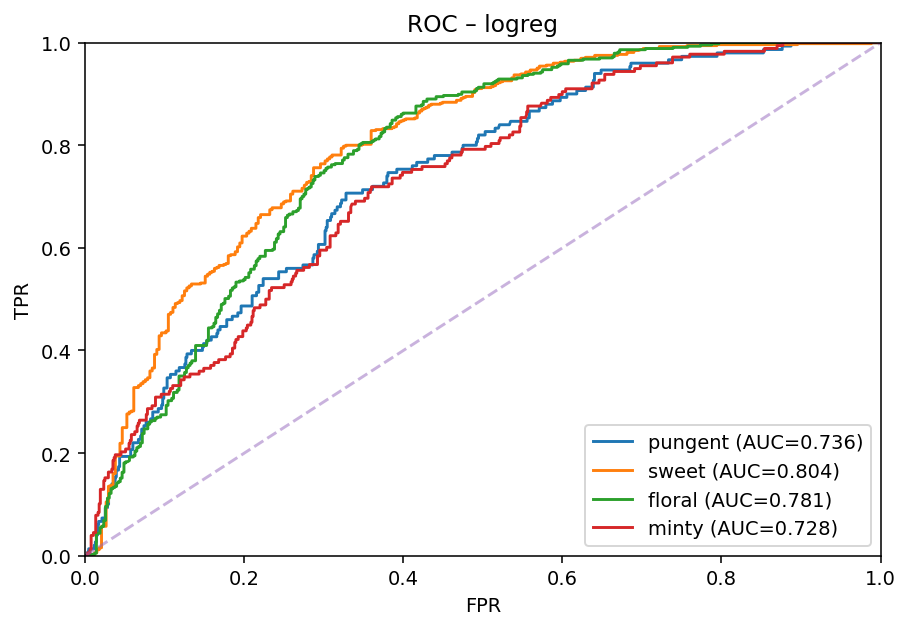

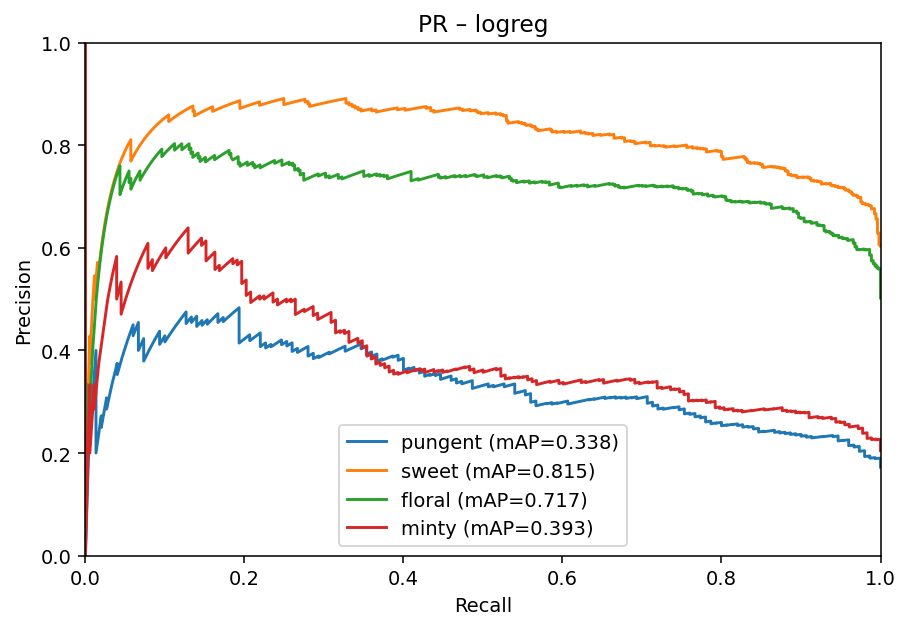


▶ rf: 5-fold CV on training set
  fold 1: ROC-AUC=0.776  PR-AUC=0.614  F1=0.617  Acc=0.719
  fold 2: ROC-AUC=0.774  PR-AUC=0.614  F1=0.611  Acc=0.714
  fold 3: ROC-AUC=0.768  PR-AUC=0.597  F1=0.607  Acc=0.715
  fold 4: ROC-AUC=0.771  PR-AUC=0.602  F1=0.614  Acc=0.721
  fold 5: ROC-AUC=0.763  PR-AUC=0.594  F1=0.607  Acc=0.706


,roc_auc,pr_auc,f1,precision,recall,accuracy_macro
mean,0.770440,0.604382,0.611329,0.521816,0.761417,0.714803
std,0.004996,0.009374,0.004484,0.007651,0.004349,0.005837



Test performance (thresholds tuned on held-out val):


,roc_auc,pr_auc,f1,accuracy_macro,subset_accuracy
rf,0.768691,0.59178,0.60589,0.751724,0.38046


,label,roc_auc,pr_auc,f1,precision,recall,threshold,accuracy
0,pungent,0.708398,0.345406,0.393939,0.361111,0.433333,0.25,0.770115
1,sweet,0.838981,0.860848,0.836457,0.756549,0.935238,0.41,0.779310
2,floral,0.815829,0.770638,0.772112,0.708015,0.848970,0.45,0.748276
3,minty,0.711555,0.390229,0.421053,0.355212,0.516854,0.28,0.709195


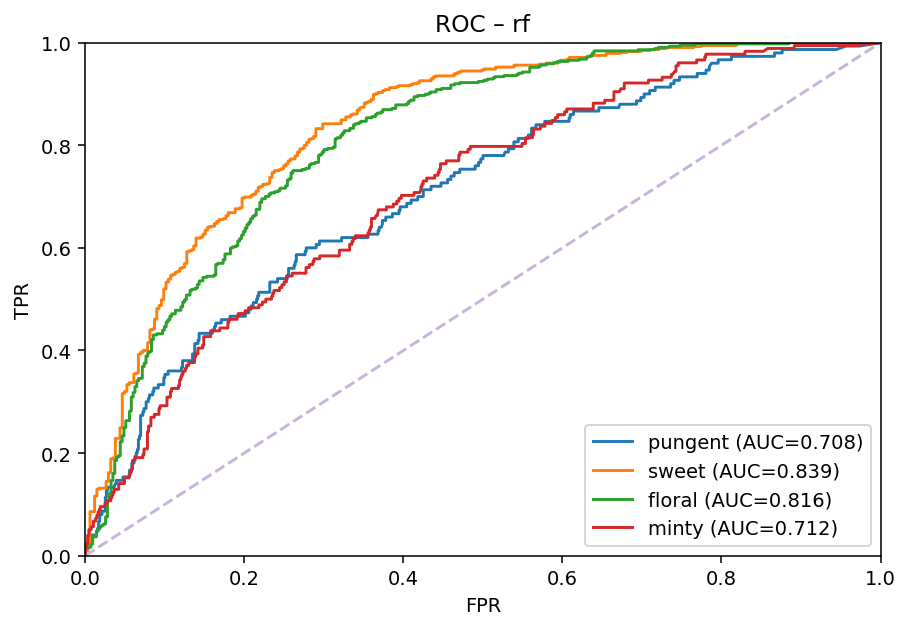

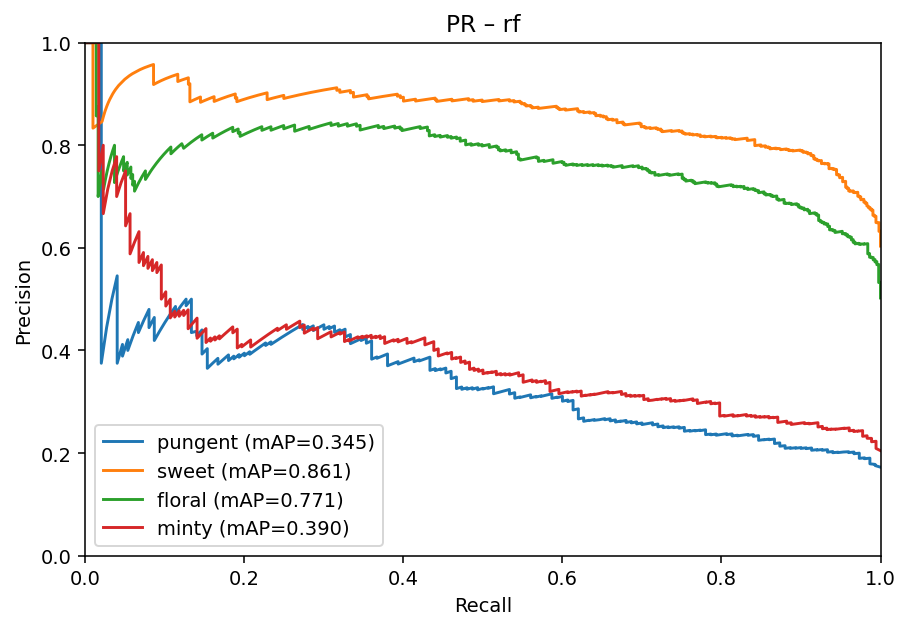


▶ xgb: 5-fold CV on training set
  fold 1: ROC-AUC=0.790  PR-AUC=0.628  F1=0.619  Acc=0.743
  fold 2: ROC-AUC=0.790  PR-AUC=0.629  F1=0.622  Acc=0.728
  fold 3: ROC-AUC=0.775  PR-AUC=0.608  F1=0.615  Acc=0.721
  fold 4: ROC-AUC=0.782  PR-AUC=0.612  F1=0.622  Acc=0.751
  fold 5: ROC-AUC=0.775  PR-AUC=0.610  F1=0.616  Acc=0.734


,roc_auc,pr_auc,f1,precision,recall,accuracy_macro
mean,0.782428,0.617364,0.618692,0.540261,0.738911,0.735512
std,0.007618,0.009964,0.003366,0.013908,0.028402,0.011713



Test performance (thresholds tuned on held-out val):


,roc_auc,pr_auc,f1,accuracy_macro,subset_accuracy
xgb,0.788637,0.615423,0.612066,0.754885,0.385057


,label,roc_auc,pr_auc,f1,precision,recall,threshold,accuracy
0,pungent,0.739037,0.379639,0.410811,0.345455,0.506667,0.13,0.749425
1,sweet,0.847299,0.877084,0.833480,0.775410,0.900952,0.42,0.782759
2,floral,0.832019,0.807239,0.763874,0.728216,0.803204,0.52,0.750575
3,minty,0.736195,0.397727,0.440098,0.389610,0.505618,0.22,0.736782


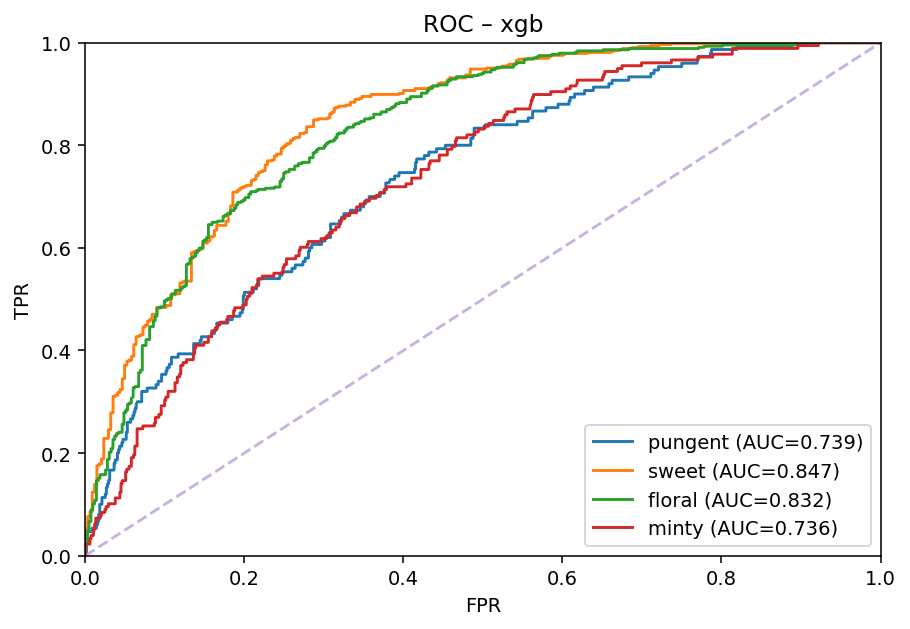

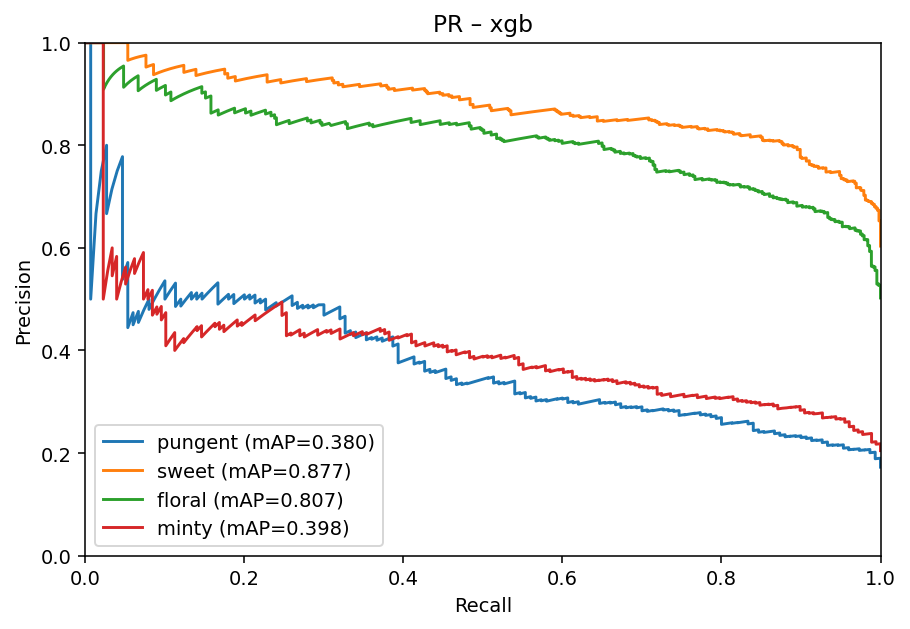

In [10]:
from pathlib import Path
import json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics

# Try XGBoost; fall back to a strong built-in GB if unavailable
try:
    from xgboost import XGBClassifier

    _xgb_ok = True
except Exception:
    _xgb_ok = False
    XGBClassifier = None

# --- output dirs
OUT = (ART / 'classical')
OUT.mkdir(parents=True, exist_ok=True)

# --- models
pipe_lr = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler(with_mean=True)),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear'))
])

pipe_rf = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('clf', RandomForestClassifier(
        n_estimators=400, class_weight='balanced_subsample',
        random_state=17, n_jobs=1
    ))
])

if _xgb_ok:
    pipe_xgb = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('clf', XGBClassifier(
            objective='binary:logistic',
            n_estimators=600, learning_rate=0.05, max_depth=6,
            subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
            tree_method='hist', n_jobs=1, eval_metric='logloss',
            random_state=17
        ))
    ])
    model_specs = [('logreg', pipe_lr), ('rf', pipe_rf), ('xgb', pipe_xgb)]
else:
    pipe_hgb = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('clf', HistGradientBoostingClassifier(
            learning_rate=0.06, max_iter=500, max_depth=None,
            random_state=17
        ))
    ])
    model_specs = [('logreg', pipe_lr), ('rf', pipe_rf), ('hgb', pipe_hgb)]


# --- helpers
def predict_proba_ovr(model, X):
    ps = []
    for est in model.estimators_:
        if hasattr(est, 'predict_proba'):
            p = est.predict_proba(X)[:, 1]
        else:
            clf = getattr(est, 'named_steps', {}).get('clf', est)
            if hasattr(clf, 'predict_proba'):
                p = est.predict_proba(X)[:, 1]
            elif hasattr(est, 'decision_function'):
                from scipy.special import expit
                p = expit(est.decision_function(X))
            else:
                p = est.predict(X)
        ps.append(p)
    return np.vstack(ps).T


def evaluate_with_accuracy(y_true, proba, thresholds, label_names):
    ev = evaluate_multilabel(y_true, proba, thresholds=thresholds, label_names=label_names)
    y_pred = (proba >= thresholds).astype(int)
    per_acc = []
    for i in range(y_true.shape[1]):
        if len(np.unique(y_true[:, i])) < 2:
            per_acc.append(np.nan)
        else:
            per_acc.append(metrics.accuracy_score(y_true[:, i], y_pred[:, i]))
    ev['per_label']['accuracy'] = per_acc
    ev['macro']['accuracy_macro'] = np.nanmean(per_acc)
    ev['subset_accuracy'] = (y_true == y_pred).all(axis=1).mean()
    return ev


def plot_roc_with_auc(y_true, proba, label_names, title, save_path: Path):
    plt.figure(figsize=(6.6, 4.6))
    for i, lab in enumerate(label_names):
        if len(np.unique(y_true[:, i])) < 2:
            continue
        fpr, tpr, _ = metrics.roc_curve(y_true[:, i], proba[:, i])
        auc = metrics.roc_auc_score(y_true[:, i], proba[:, i])
        plt.plot(fpr, tpr, label=f"{lab} (AUC={auc:.3f})")
    plt.plot([0, 1], [0, 1], '--', alpha=0.5)
    plt.title(title)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.xlim(0, 1)           # comparable axes
    plt.ylim(0, 1)           # comparable axes
    plt.xticks(np.linspace(0, 1, 6))
    plt.yticks(np.linspace(0, 1, 6))
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=160);
    plt.show()


def plot_pr_with_ap(y_true, proba, label_names, title, save_path: Path):
    plt.figure(figsize=(6.6, 4.6))
    for i, lab in enumerate(label_names):
        if len(np.unique(y_true[:, i])) < 2:
            continue
        pr, rc, _ = metrics.precision_recall_curve(y_true[:, i], proba[:, i])
        ap = metrics.average_precision_score(y_true[:, i], proba[:, i])
        plt.plot(rc, pr, label=f"{lab} (mAP={ap:.3f})")
    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim(0, 1)           # comparable axes
    plt.ylim(0, 1)           # comparable axes
    plt.xticks(np.linspace(0, 1, 6))
    plt.yticks(np.linspace(0, 1, 6))
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=160)
    plt.show()


def run_cv_and_test(name, base_pipe):
    print(f"\n▶ {name}: 5-fold CV on training set")
    cv_macro = []
    for fold, (tr_idx_cv, va_idx_cv) in enumerate(cv_folds, 1):
        model = OneVsRestClassifier(base_pipe, n_jobs=1)
        Xt, Xv = Xtr.iloc[tr_idx_cv], Xtr.iloc[va_idx_cv]
        yt, yv = ytr[tr_idx_cv], ytr[va_idx_cv]
        model.fit(Xt, yt)
        p_v = predict_proba_ovr(model, Xv)
        thr_v = optimize_thresholds(yv, p_v)
        ev_v = evaluate_with_accuracy(yv, p_v, thresholds=thr_v, label_names=label_names)
        cv_macro.append(ev_v['macro'])
        print(f"  fold {fold}: ROC-AUC={ev_v['macro']['roc_auc']:.3f}  PR-AUC={ev_v['macro']['pr_auc']:.3f}  "
              f"F1={ev_v['macro']['f1']:.3f}  Acc={ev_v['macro']['accuracy_macro']:.3f}")

    # summarize CV to disk
    cv_df = pd.DataFrame(cv_macro)
    cv_summary = cv_df.agg(['mean', 'std']).round(6)
    cv_df.to_csv(OUT / f"{name}_cv_macro_folds.csv", index=False)
    cv_summary.to_csv(OUT / f"{name}_cv_macro_summary.csv")
    display(cv_summary)

    # retrain on full train set, tune thresholds on held-out val, evaluate on test
    final = OneVsRestClassifier(base_pipe, n_jobs=1)
    final.fit(Xtr, ytr)

    p_va = predict_proba_ovr(final, Xva)
    thr = optimize_thresholds(yva, p_va)
    np.save(OUT / f"{name}_thresholds.npy", thr)

    p_te = predict_proba_ovr(final, Xte)
    ev_te = evaluate_with_accuracy(yte, p_te, thresholds=thr, label_names=label_names)

    # save test metrics + probabilities
    macro_out = pd.DataFrame({
        "roc_auc": [ev_te["macro"]["roc_auc"]],
        "pr_auc": [ev_te["macro"]["pr_auc"]],
        "f1": [ev_te["macro"]["f1"]],
        "accuracy_macro": [ev_te["macro"]["accuracy_macro"]],
        "subset_accuracy": [ev_te["subset_accuracy"]],
    }, index=[name])

    macro_out.to_csv(OUT / f"{name}_macro.csv")
    ev_te["per_label"].to_csv(OUT / f"{name}_per_label_metrics.csv", index=False)

    test_probs = pd.DataFrame(p_te, columns=[f"prob_{l}" for l in label_names], index=df.index[te_idx])
    test_probs.index.name = "row_id"
    test_probs.to_csv(OUT / f"{name}_test_probs.csv")

    print("\nTest performance (thresholds tuned on held-out val):")
    display(macro_out);
    display(ev_te["per_label"])

    # plots with AUC/mAP in legends -> also saved
    plot_roc_with_auc(yte, p_te, label_names, f"ROC – {name}", OUT / f"{name}_roc.png")
    plot_pr_with_ap(yte, p_te, label_names, f"PR – {name}", OUT / f"{name}_pr.png")


# --- run all models
for model_name, base_pipe in model_specs:
    run_cv_and_test(model_name, base_pipe)

## 6) Artifacts & reproducibility

**Goal.**
Make reruns painless and auditable.

**Saved artifacts.**
- `features/mordred.parquet`
- `data/molecule_scent_labels_with_probs.csv`
- `artifacts/classical/*` – (per-model JSON/CSV + plots)

**Repro steps.**
1. Create env from environment.yml.
2. Open the notebook, run top-to-bottom.
3. All heavy steps cache their outputs.

In [11]:
# Save splits + manifest under artifacts/classical/
np.save(OUT / 'tr_idx.npy', tr_idx);
np.save(OUT / 'va_idx.npy', va_idx);
np.save(OUT / 'te_idx.npy', te_idx)
manifest = {
    'data_csv': str(PROB_CSV),
    'features_parquet': str(mordred_parquet),
    'label_cols': label_cols,
    'n_rows': int(len(df))
}
json.dump(manifest, open(OUT / 'manifest.json', 'w'), indent=2)
print('✔ Wrote artifacts to', OUT.resolve())

✔ Wrote artifacts to /Users/shirsegev/Documents/PycharmProjects/ScentPrediction/artifacts/classical
